In [78]:
import pandas as pd
import numpy as np
import geopandas as gp
import seaborn as sn
import datetime as dt
import pylab as pl
import urllib.request
from urllib.request import urlretrieve
import zipfile
import statsmodels as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
%pylab inline

/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['math']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
pd.set_option('display.max_columns', 500)

# SECTION 1. 311 DATA MUNGING 

In [ ]:
# Get the data form the open data website
# Just run if you do not have already one of the clean datasets, it takes a while to get the data
df = pd.read_csv("https://data.cityofnewyork.us/api/views/erm2-nwe9/rows.csv?accessType=DOWNLOAD")

In [3]:
# Visualize the first 5 observations of the data
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,36412235,06/09/2017 08:01:53 AM,06/29/2017 01:30:18 PM,HPD,Department of Housing Preservation and Develop...,PAINT/PLASTER,WALL,RESIDENTIAL BUILDING,11204,6801 BAY PARKWAY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.611923,-73.983414,"(40.611923387615, -73.98341420024296)"
1,36412238,06/10/2017 08:31:35 AM,06/10/2017 01:22:05 PM,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,11218,633 EAST 3 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.636672,-73.976119,"(40.63667188103406, -73.9761191202944)"
2,36412246,06/10/2017 03:00:29 PM,06/10/2017 03:24:32 PM,NYPD,New York City Police Department,Blocked Driveway,Partial Access,Street/Sidewalk,10025,WEST 95 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.794163,-73.972726,"(40.79416271434158, -73.97272555078482)"
3,36412247,06/10/2017 09:58:21 AM,06/10/2017 03:17:27 PM,NYPD,New York City Police Department,Blocked Driveway,Partial Access,Street/Sidewalk,10039,2987 8 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.830730,-73.936134,"(40.830729904331186, -73.93613432501654)"
4,36412248,06/10/2017 06:51:55 PM,06/10/2017 10:14:41 PM,NYPD,New York City Police Department,Blocked Driveway,Partial Access,Street/Sidewalk,11369,106-14 DITMARS BOULEVARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.765496,-73.863849,"(40.765496327953315, -73.86384884813525)"


In [4]:
# Look at the shape of the data
df.shape

(9327811, 53)

We can see how big the entire dataset is! We need some cleaning. First just get the years we are interested in (2013, 2014 and 2015) then get rid of some columns we really do not need, then just keep the Noise complaints that are the main focus of our work.

In [5]:
# Visualize all the columns the data has
df.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Park Facility Name', 'Park Borough',
       'School Name', 'School Number', 'School Region', 'School Code',
       'School Phone Number', 'School Address', 'School City', 'School State',
       'School Zip', 'School Not Found', 'School or Citywide Complaint',
       'Vehicle Type', 'Taxi Company Borough', 'Taxi Pick Up Location',
       'Bridge Highway Name', 'Bridge Highway Direction', 'Road Ramp',
       'Bridge Highway Segment', 'Garage Lot Name', 'Ferry 

In [6]:
# Visualize the complaint types so that we get only noise
df["Complaint Type"].unique()

array(['PAINT/PLASTER', 'Blocked Driveway', 'PLUMBING', 'Noise - Park',
       'Illegal Parking', 'UNSANITARY CONDITION', 'Derelict Vehicles',
       'Sanitation Condition', 'Missed Collection (All Materials)',
       'Homeless Person Assistance', 'WATER LEAK', 'HEAT/HOT WATER',
       'Noise - Residential', 'Noise', 'New Tree Request', 'DOOR/WINDOW',
       'Sewer', 'Illegal Tree Damage', 'Noise - Commercial',
       'Water System', 'Water Conservation', 'Taxi Complaint',
       'Animal Abuse', 'Street Condition', 'Damaged Tree',
       'Non-Emergency Police Matter', 'Street Sign - Damaged', 'Smoking',
       'Overgrown Tree/Branches', 'ELECTRIC', 'Noise - Vehicle',
       'Elevator', 'FLOORING/STAIRS',
       'Request Large Bulky Item Collection', 'Dead/Dying Tree',
       'Plumbing', 'APPLIANCE', 'Violation of Park Rules',
       'Maintenance or Facility', 'ELEVATOR', 'GENERAL', 'SAFETY',
       'Street Sign - Missing', 'General Construction/Plumbing',
       'Dirty Conditions', 'No

In [7]:
# Check the variable type of Created Date.
type(df['Created Date'].iloc[1])

str

In [28]:
noise = df[df["Complaint Type"] == "Noise"]

In [29]:
# Convert to date time
noise['Created Date'] = pd.to_datetime(noise['Created Date'])

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [30]:
# Set the maximum and minimum dates we want in our dataset
start_date = '01/01/2013'
end_date = '12/31/2015'

noise =  noise[noise["Created Date"]>start_date]
noise =  noise[noise["Created Date"]<end_date]

In [31]:
# See how many observations we dropped
print (df.shape)
print (noise.shape)

(9327811, 53)
(146301, 53)


In [32]:
noise.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Park Facility Name', 'Park Borough',
       'School Name', 'School Number', 'School Region', 'School Code',
       'School Phone Number', 'School Address', 'School City', 'School State',
       'School Zip', 'School Not Found', 'School or Citywide Complaint',
       'Vehicle Type', 'Taxi Company Borough', 'Taxi Pick Up Location',
       'Bridge Highway Name', 'Bridge Highway Direction', 'Road Ramp',
       'Bridge Highway Segment', 'Garage Lot Name', 'Ferry 

In [34]:
# We keep only the columns we are interested in
noise = noise[["Unique Key", "Created Date", "Agency", "Agency Name", 
         "Complaint Type", "Descriptor", "Incident Zip", "Community Board", "Borough", "School Name", 
         "School Number", "School Code", "School or Citywide Complaint", "Latitude", "Longitude", "Location"]]

In [35]:
noise.shape

(146301, 16)

In [46]:
# We are only interested in observations we can geo localize so we check if the column has nan values.
noise1 = noise[noise['Location']=="NaN"]

In [47]:
noise.shape

(146301, 16)

In [48]:
noise1.shape

# It doesn't have any NaN values. How great!

(0, 16)

In [50]:
# We save the data as a csv file in case we want to reload it without spending so much time
noise.to_csv('311data.csv')

In [51]:
noise.head()

,Unique Key,Created Date,Agency,Agency Name,Complaint Type,Descriptor,Incident Zip,Community Board,Borough,School Name,School Number,School Code,School or Citywide Complaint,Latitude,Longitude,Location
203401,29121436,2014-10-22 01:16:00,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),10003,03 MANHATTAN,MANHATTAN,Unspecified,Unspecified,Unspecified,NaN,40.732354,-73.987855,"(40.73235370534885, -73.98785478843209)"
304668,31128978,2015-07-21 22:31:00,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),11218,14 BROOKLYN,BROOKLYN,Unspecified,Unspecified,Unspecified,NaN,40.645393,-73.969781,"(40.64539331933518, -73.96978104471124)"
304964,31310515,2015-08-14 00:13:00,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),11692,14 QUEENS,QUEENS,Unspecified,Unspecified,Unspecified,NaN,40.591418,-73.791317,"(40.591418105600994, -73.7913169371139)"
305039,31350851,2015-08-19 07:09:00,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),11368,03 QUEENS,QUEENS,Unspecified,Unspecified,Unspecified,NaN,40.754693,-73.864145,"(40.754693353809444, -73.86414524439152)"
305223,31476576,2015-09-06 16:19:00,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),11211,01 BROOKLYN,BROOKLYN,Unspecified,Unspecified,Unspecified,NaN,40.718651,-73.953089,"(40.718651195412065, -73.95308857167933)"


In [52]:
noise.shape

(146301, 16)

In [53]:
# We group the noise complaints in differen time subsets in order to visualize them
grph = noise.groupby(noise["Created Date"].dt.hour).count()
grpd = noise.groupby(noise["Created Date"].dt.weekday).count()
grpw = noise.groupby(noise["Created Date"].dt.week).count()
grpy = noise.groupby(noise["Created Date"].dt.year).count()

In [55]:
grpd.head(1)

,Unique Key,Created Date,Agency,Agency Name,Complaint Type,Descriptor,Incident Zip,Community Board,Borough,School Name,School Number,School Code,School or Citywide Complaint,Latitude,Longitude,Location
Created Date,,,,,,,,,,,,,,,,
0,20128,20128,20128,20128,20128,20128,20041,20128,20128,20128,20128,20128,0,19986,19986,19986


Text(0.5,1,'Complaints in NYC')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


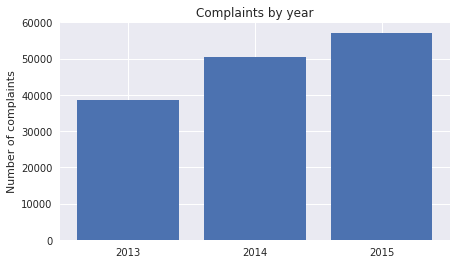

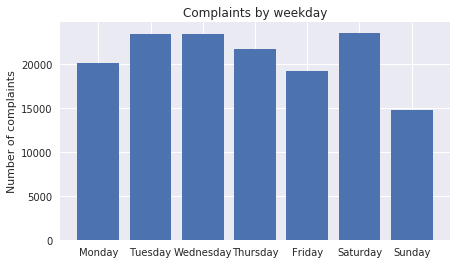

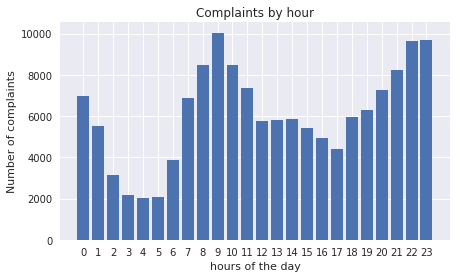

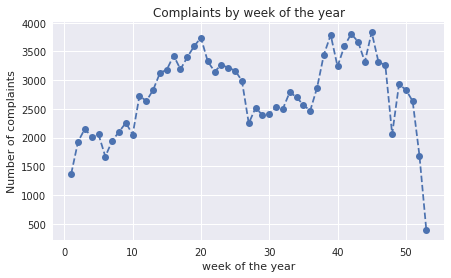

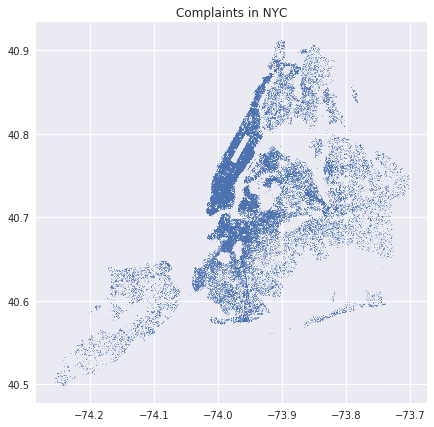

In [56]:
fig = plt.figure(figsize=(7,4))

wd = np.arange(3)
ax1 =plt.bar(wd, grpy["Unique Key"])
plt.xticks(wd, ('2013', '2014', '2015'))
pl.title("Complaints by year")
pl.ylabel("Number of complaints")

fig = plt.figure(figsize=(7,4))

wd = np.arange(7)
ax1 =plt.bar(wd, grpd["Unique Key"])
plt.xticks(wd, ('Monday', 'Tuesday', 'Wednesday', 'Thursday', "Friday", "Saturday", "Sunday"))
pl.title("Complaints by weekday")
pl.ylabel("Number of complaints")

fig = plt.figure(figsize=(7,4))

x = np.arange(24)
ax2 = plt.bar(x, grph["Unique Key"])
plt.xticks(x, ('0', '1', '2', '3', "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14",
              "15", "16", "17", "18", "19", "20", "21", "22", "23"))
pl.title("Complaints by hour")
pl.ylabel("Number of complaints")
pl.xlabel("hours of the day")

fig = plt.figure(figsize=(7,4))
ax3 = plt.figure(figsize=(7,4))
pl.plot(grpw["Unique Key"], "--o")
pl.title("Complaints by week of the year")
pl.ylabel("Number of complaints")
pl.xlabel("week of the year")

pl.figure(figsize=(7,7))
ax4 = pl.scatter(noise.Longitude, noise.Latitude, s = 0.1)
pl.title("Complaints in NYC")

In [58]:
# We drop Saturdays and Sundays because kids do not go to school those days
noise =  noise[noise["Created Date"].dt.weekday!=6]
noise =  noise[noise["Created Date"].dt.weekday!=7]

In [60]:
print ("This is our final 311 database complaint database shape:", noise.shape)

This is our final 311 database complaint database shape: (131532, 16)


In [61]:
# Because our school results are by year then we also want our noise complaints by year
noise2013 = noise[noise["Created Date"].dt.year == 2013]
noise2014 = noise[noise["Created Date"].dt.year == 2014]
noise2015 = noise[noise["Created Date"].dt.year == 2015]

In [62]:
# We create three different datasets of noise complaints (1 by year in order to groupby census tract)
noise2013.to_csv("noise2013.csv")
noise2014.to_csv("noise2014.csv")
noise2015.to_csv("noise2015.csv")

### NOTE: in order to count the number of complaints by Census Tract we used "Carto" using the analysis of counting points inside geometries. The geometries were the census tracts provided by new york city open data. It will we used in the following data processing.  

In [64]:
# We read the resulting datasets that contain the number of complaints by Census Tract
noise_13 = pd.read_csv("noisebyct2013.csv")
noise_14 = pd.read_csv("noisebyct2014.csv")
noise_15 = pd.read_csv("noisebyct2015.csv")

In [71]:
print (noise_13.shape)
print (noise_14.shape)
print (noise_15.shape)

(2028, 15)
(2054, 15)
(2070, 15)


In [4]:
# This is a way to visualize NYC that professor Federica Bianco created, it is basically a choropleth with variations.
urllib.request.urlretrieve("https://raw.githubusercontent.com/fedhere/choroplethNYC/master/choroplethNYC.py","choroplethNYC.py")
import choroplethNYC as cp

In [81]:
# Make the datasets geo data frames in order to map them
noise_13_ = gp.GeoDataFrame(noise_13)
noise_14_ = gp.GeoDataFrame(noise_14)
noise_15_ = gp.GeoDataFrame(noise_15)

In [75]:
#we unzip the census tract shapefile (it will be attached with the code in a separate file)
zip_ref = zipfile.ZipFile("2010 Census Tracts.zip", 'r')
zip_ref.extractall()
zip_ref.close()

In [2]:
# We read the file as a geodataframe
ct = gp.GeoDataFrame.from_file("geo_export_19d388ec-f34e-4b0d-b74d-a31e738347e7.shp")

OSError: no such file or directory: 'geo_export_19d388ec-f34e-4b0d-b74d-a31e738347e7.shp'

In [77]:
ct.head(1)

,puma,boro_ct201,ct2010,ntaname,ntacode,boro_name,shape_leng,shape_area,cdeligibil,boro_code,ctlabel,geometry
0,3903,5000900,000900,West New Brighton-New Brighton-St. George,SI22,Staten Island,7729.016794,2.497010e+06,I,5,9,POLYGON ((-74.07920577013245 40.64343078374567...


In [72]:
noise_13_.columns

Index(['cartodb_id', 'the_geom', 'puma', 'boro_ct201', 'ct2010', 'ntaname',
       'ntacode', 'boro_name', 'shape_leng', 'shape_area', 'cdeligibil',
       'boro_code', 'ctlabel', 'count_vals', 'count_vals_density'],
      dtype='object')

In [83]:
noise_13_["boro_ct201"] = noise_13_["boro_ct201"].astype(str)
noise_14_["boro_ct201"] = noise_14_["boro_ct201"].astype(str)
noise_15_["boro_ct201"] = noise_15_["boro_ct201"].astype(str)

ct["boro_ct201"] = ct["boro_ct201"].astype(str)


In [84]:
# In order to map the number of complaints by census tract we must merge the datasets

noise_13_ = pd.merge(ct, noise_13_, on="boro_ct201")
noise_14_ = pd.merge(ct, noise_14_, on="boro_ct201")
noise_15_ = pd.merge(ct, noise_15_, on="boro_ct201")

In [85]:
noise_13_.head()

,puma_x,boro_ct201,ct2010_x,ntaname_x,ntacode_x,boro_name_x,shape_leng_x,shape_area_x,cdeligibil_x,boro_code_x,...,ntaname_y,ntacode_y,boro_name_y,shape_leng_y,shape_area_y,cdeligibil_y,boro_code_y,ctlabel_y,count_vals,count_vals_density
0,3903,5000900,000900,West New Brighton-New Brighton-St. George,SI22,Staten Island,7729.016794,2.497010e+06,I,5,...,West New Brighton-New Brighton-St. George,SI22,Staten Island,7729.016794,2.497010e+06,I,5,9.0,1.0,0.000004
1,3808,1009800,009800,Turtle Bay-East Midtown,MN19,Manhattan,5534.199811,1.906016e+06,I,1,...,Turtle Bay-East Midtown,MN19,Manhattan,5534.199811,1.906016e+06,I,1,98.0,237.0,0.001338
2,3808,1010000,010000,Turtle Bay-East Midtown,MN19,Manhattan,5692.168737,1.860938e+06,I,1,...,Turtle Bay-East Midtown,MN19,Manhattan,5692.168737,1.860938e+06,I,1,100.0,78.0,0.000451
3,3807,1010200,010200,Midtown-Midtown South,MN17,Manhattan,5687.802439,1.860993e+06,I,1,...,Midtown-Midtown South,MN17,Manhattan,5687.802439,1.860993e+06,I,1,102.0,53.0,0.000307
4,3807,1010400,010400,Midtown-Midtown South,MN17,Manhattan,5693.036367,1.864600e+06,I,1,...,Midtown-Midtown South,MN17,Manhattan,5693.036367,1.864600e+06,I,1,104.0,90.0,0.000520


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


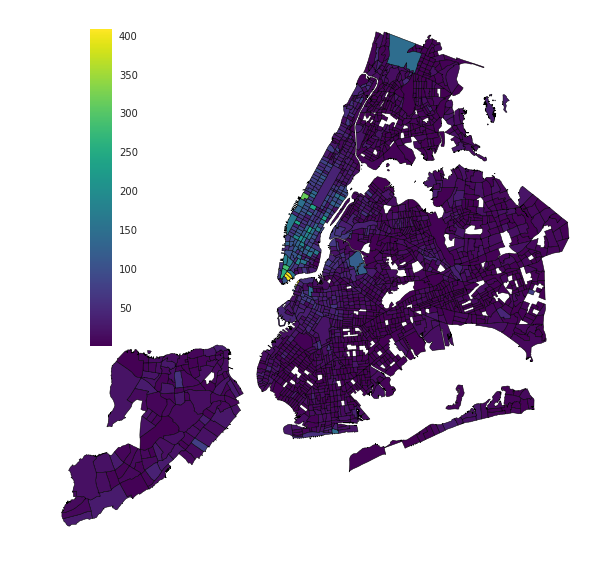

In [86]:
cp.choroplethNYC(noise_13_, column="count_vals", color="k",cmap="viridis", edgecolor="k", lw=0.5);

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


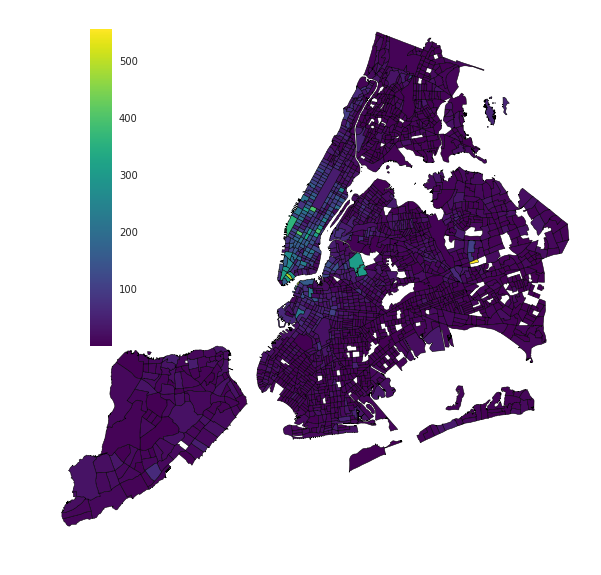

In [87]:
cp.choroplethNYC(noise_14_, column="count_vals", color="k",cmap="viridis", edgecolor="k", lw=0.5);

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


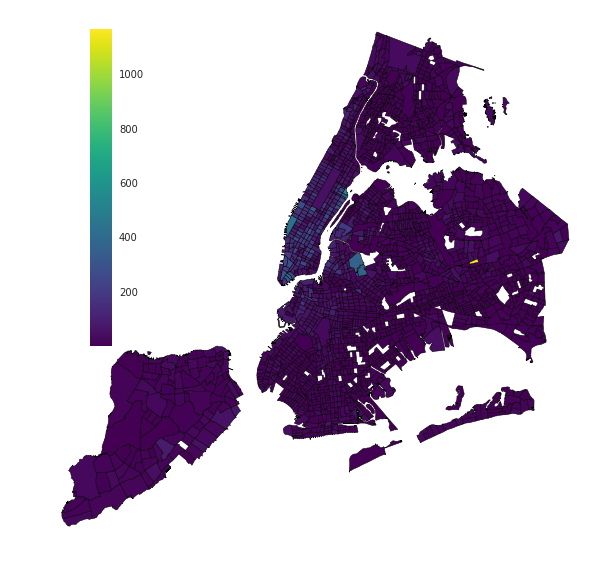

In [88]:
cp.choroplethNYC(noise_15_, column="count_vals", color="k",cmap="viridis", edgecolor="k", lw=0.5);

# SECTION 2. SCHOOL DATA MUNGING 

In [5]:
#load english and math scores and school locations from nyc open data 
math = pd.read_csv("https://data.cityofnewyork.us/api/views/gcvr-n8qw/rows.csv?accessType=DOWNLOAD")

In [6]:
english = pd.read_csv("https://data.cityofnewyork.us/api/views/jk35-yh5p/rows.csv?accessType=DOWNLOAD")


In [7]:
loc = pd.read_csv("https://data.cityofnewyork.us/api/views/ac4n-c5re/rows.csv?accessType=DOWNLOAD")

In [8]:
print(math.shape)
print(english.shape)
print(loc.shape)

(161403, 17)
(161412, 17)
(1819, 39)


In [9]:
english.columns

Index(['DBN', 'School Name', 'Grade', 'Year', 'Category', 'Number Tested',
       'Mean Scale Score', '# Level 1', '% Level 1', '# Level 2', '% Level 2',
       '# Level 3', '% Level 3', '# Level 4', '% Level 4', '# Level 3+4',
       '% Level 3+4'],
      dtype='object')

In [10]:
english.head()

,DBN,School Name,Grade,Year,Category,Number Tested,Mean Scale Score,# Level 1,% Level 1,# Level 2,% Level 2,# Level 3,% Level 3,# Level 4,% Level 4,# Level 3+4,% Level 3+4
0,01M015,P.S. 015 ROBERTO CLEMENTE,3,2013,All Students,27,289,14,51.9,11,40.7,2,7.4,0,0,2,7.4
1,01M015,P.S. 015 ROBERTO CLEMENTE,3,2014,All Students,18,285,10,55.6,8,44.4,0,0,0,0,0,0
2,01M015,P.S. 015 ROBERTO CLEMENTE,3,2015,All Students,16,282,9,56.3,5,31.3,2,12.5,0,0,2,12.5
3,01M015,P.S. 015 ROBERTO CLEMENTE,4,2013,All Students,20,278,8,40,11,55,1,5,0,0,1,5
4,01M015,P.S. 015 ROBERTO CLEMENTE,4,2014,All Students,24,284,13,54.2,10,41.7,1,4.2,0,0,1,4.2


In [11]:
loc.columns

Index(['FISCAL_YEAR', 'ATS SYSTEM CODE', 'LOCATION_CODE', 'LOCATION_NAME',
       'BEDS NUMBER', 'MANAGED_BY_NAME', 'LOCATION_TYPE_DESCRIPTION',
       'LOCATION_CATEGORY_DESCRIPTION', 'GRADES_TEXT', 'GRADES_FINAL_TEXT',
       'OPEN_DATE', 'STATUS_DESCRIPTIONS', 'PRIMARY_BUILDING_CODE',
       'PRIMARY_ADDRESS_LINE_1', 'STATE_CODE', 'X_COORDINATE', 'Y_COORDINATE',
       'COMMUNITY_DISTRICT', 'COUNCIL_DISTRICT', 'CENSUS_TRACT',
       'BOROUGH_BLOCK_LOT', 'NTA', 'NTA_NAME', 'PRINCIPAL_NAME',
       'PRINCIPAL_TITLE', 'PRINCIPAL_PHONE_NUMBER', 'FAX_NUMBER',
       'GEOGRAPHICAL_DISTRICT_CODE', 'ADMIN_DISTRICT_LOCATION_CODE',
       'ADMINISTRATIVE_DISTRICT_NAME', 'COMMUNITY_SCHOOL_SUP_NAME',
       'FIELD_SUPPORT_CENTER_NAME', 'FIELD_SUPPORT_CENTER_LEADER_NAME',
       'SCHOOL_SUPPORT_TEAM_NAME', 'SCHOOL_SUPPORT_TEAM_LEADER_NAME',
       'HIGHSCHOOL_NETWORK_LOCATION_CODE', 'HIGHSCHOOL_NETWORK_NAME',
       'HIGHSCHOOL_NETWORK_SUPERINTENDENT', 'Location 1'],
      dtype='object')

In [12]:
print(len(math.DBN.unique()))
print(len(english.DBN.unique()))

1133
1132


In [13]:
#shorten english and math dataframes to only include average scores from all grades
english = english[english["Grade"] == "All Grades"]
math = math[math["Grade"] == "All Grades"]

In [14]:
print(english.shape)
print(math.shape)

(38930, 17)
(38978, 17)


In [15]:
#create dataframes for each year of test scores
english2013 = english[english["Year"] == 2013]
english2014 = english[english["Year"] == 2014]
english2015 = english[english["Year"] == 2015]

math2013 = math[math["Year"] == 2013]
math2014 = math[math["Year"] == 2014]
math2015 = math[math["Year"] == 2015]

In [16]:
print("math 2013",math2013.shape)
print("math 2014",math2014.shape)
print("math 2015",math2015.shape)

print("english 2013",english2013.shape)
print("english 2014",english2014.shape)
print("english 2015",english2015.shape)

math 2013 (12730, 17)
math 2014 (13026, 17)
math 2015 (13222, 17)
english 2013 (12715, 17)
english 2014 (13012, 17)
english 2015 (13203, 17)


In [17]:
#create BDN column in location data
loc["DBN"] = loc["ATS SYSTEM CODE"].str[:6]

In [18]:
loc.columns

Index(['FISCAL_YEAR', 'ATS SYSTEM CODE', 'LOCATION_CODE', 'LOCATION_NAME',
       'BEDS NUMBER', 'MANAGED_BY_NAME', 'LOCATION_TYPE_DESCRIPTION',
       'LOCATION_CATEGORY_DESCRIPTION', 'GRADES_TEXT', 'GRADES_FINAL_TEXT',
       'OPEN_DATE', 'STATUS_DESCRIPTIONS', 'PRIMARY_BUILDING_CODE',
       'PRIMARY_ADDRESS_LINE_1', 'STATE_CODE', 'X_COORDINATE', 'Y_COORDINATE',
       'COMMUNITY_DISTRICT', 'COUNCIL_DISTRICT', 'CENSUS_TRACT',
       'BOROUGH_BLOCK_LOT', 'NTA', 'NTA_NAME', 'PRINCIPAL_NAME',
       'PRINCIPAL_TITLE', 'PRINCIPAL_PHONE_NUMBER', 'FAX_NUMBER',
       'GEOGRAPHICAL_DISTRICT_CODE', 'ADMIN_DISTRICT_LOCATION_CODE',
       'ADMINISTRATIVE_DISTRICT_NAME', 'COMMUNITY_SCHOOL_SUP_NAME',
       'FIELD_SUPPORT_CENTER_NAME', 'FIELD_SUPPORT_CENTER_LEADER_NAME',
       'SCHOOL_SUPPORT_TEAM_NAME', 'SCHOOL_SUPPORT_TEAM_LEADER_NAME',
       'HIGHSCHOOL_NETWORK_LOCATION_CODE', 'HIGHSCHOOL_NETWORK_NAME',
       'HIGHSCHOOL_NETWORK_SUPERINTENDENT', 'Location 1', 'DBN'],
      dtype='object')

In [19]:
#merge school locations and test scores based on DBN
eng2013 = pd.merge(loc, english2013, right_on="DBN", left_on="DBN", how = "inner")
eng2014 = pd.merge(loc, english2014, right_on="DBN", left_on="DBN", how = "inner")
eng2015 = pd.merge(loc, english2015, right_on="DBN", left_on="DBN", how = "inner")

math2013 = pd.merge(loc, math2013, right_on="DBN", left_on="DBN", how = "inner")
math2014 = pd.merge(loc, math2014, right_on="DBN", left_on="DBN", how = "inner")
math2015 = pd.merge(loc, math2015, right_on="DBN", left_on="DBN", how = "inner")

In [20]:
print("math 2013",math2013.shape)
print("math 2014",math2014.shape)
print("math 2015",math2015.shape)

print("english 2013",english2013.shape)
print("english 2014",english2014.shape)
print("english 2015",english2015.shape)

math 2013 (12730, 56)
math 2014 (13026, 56)
math 2015 (13139, 56)
english 2013 (12715, 17)
english 2014 (13012, 17)
english 2015 (13203, 17)


In [21]:
eng2013 = eng2013[eng2013["Mean Scale Score"].str.contains("s") == False]
eng2014 = eng2014[eng2014["Mean Scale Score"].str.contains("s") == False]
eng2015 = eng2015[eng2015["Mean Scale Score"].str.contains("s") == False]

math2013 = math2013[math2013["Mean Scale Score"].str.contains("s") == False]
math2014 = math2014[math2014["Mean Scale Score"].str.contains("s") == False]
math2015 = math2015[math2015["Mean Scale Score"].str.contains("s") == False]

In [22]:
#convert mean scale score to integer
eng2013["mean"] = eng2013["Mean Scale Score"].astype(int)
eng2014["mean"] = eng2014["Mean Scale Score"].astype(int)
eng2015["mean"] = eng2015["Mean Scale Score"].astype(int)

math2013["mean"] = math2013["Mean Scale Score"].astype(int)
math2014["mean"] = math2014["Mean Scale Score"].astype(int)
math2015["mean"] = math2015["Mean Scale Score"].astype(int)

In [23]:
engall2013 = eng2013[eng2013["Category"] == "All Students"]
engall2014 = eng2014[eng2014["Category"] == "All Students"]
engall2015 = eng2015[eng2015["Category"] == "All Students"]

mathall2013 = math2013[math2013["Category"] == "All Students"]
mathall2014 = math2014[math2014["Category"] == "All Students"]
mathall2015 = math2015[math2015["Category"] == "All Students"]

In [24]:
print(engall2013.shape)
print(engall2014.shape)
print(engall2015.shape)

print(mathall2013.shape)
print(mathall2014.shape)
print(mathall2015.shape)

(1086, 57)
(1115, 57)
(1124, 57)
(1086, 57)
(1115, 57)
(1125, 57)


In [25]:
engall2013["English Mean Score"] = engall2015["mean"]
engall2014["English Mean Score"] = engall2015["mean"]
engall2015["English Mean Score"] = engall2015["mean"]

mathall2013["Math Mean Score"] = mathall2015["mean"]
mathall2014["Math Mean Score"] = mathall2015["mean"]
mathall2015["Math Mean Score"] = mathall2015["mean"]

/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [26]:
#examine mean test scores in each year

Text(0.5,0,'English scores')

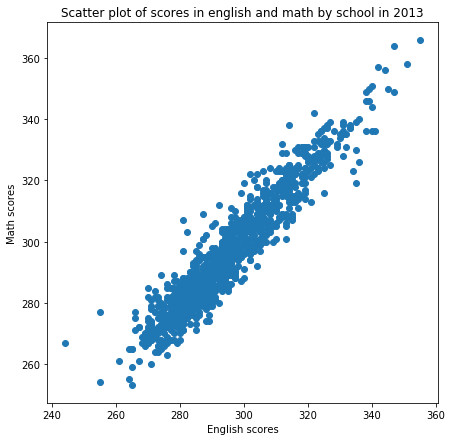

In [27]:
#2013
pl.figure(figsize=(7,7))
pl.scatter(engall2013["mean"], mathall2013["mean"])
pl.title("Scatter plot of scores in english and math by school in 2013")
pl.ylabel("Math scores")
pl.xlabel("English scores")

Text(0.5,0,'English scores')

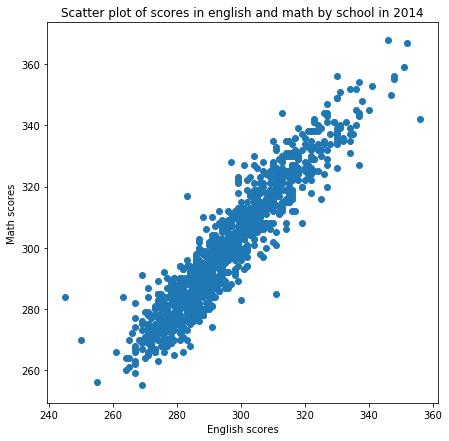

In [28]:
#2014
pl.figure(figsize=(7,7))
pl.scatter(engall2014["mean"], mathall2014["mean"])
pl.title("Scatter plot of scores in english and math by school in 2014")
pl.ylabel("Math scores")
pl.xlabel("English scores")

Text(0.5,0,'English scores')

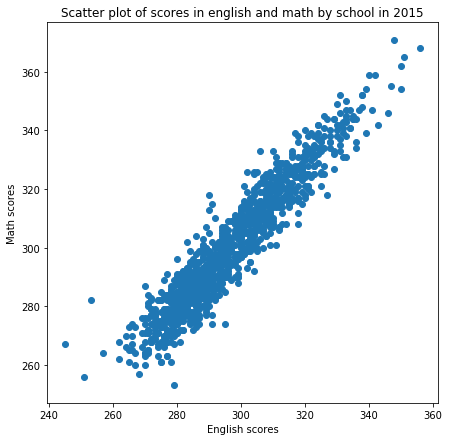

In [29]:
#for 2015 we must first merge english and math scores to drop additional school in math data
a = pd.merge(engall2015, mathall2015, on = "DBN")

pl.figure(figsize=(7,7))
pl.scatter(a["English Mean Score"], a["Math Mean Score"])
pl.title("Scatter plot of scores in english and math by school in 2015")
pl.ylabel("Math scores")
pl.xlabel("English scores")

In [30]:
#now we merge the test score data with the census tracts

In [31]:
ct = pd.read_csv("nyct2010.csv")

In [32]:
ct.columns

Index(['CTLabel', 'the_geom', 'BoroName', 'BoroCode', 'CT2010', 'BoroCT2010',
       'CDEligibil', 'NTACode', 'NTAName', 'PUMA', 'Shape_Leng', 'Shape_Area'],
      dtype='object')

In [33]:
ct.dtypes

CTLabel       float64
the_geom       object
BoroName       object
BoroCode        int64
CT2010          int64
BoroCT2010      int64
CDEligibil     object
NTACode        object
NTAName        object
PUMA            int64
Shape_Leng    float64
Shape_Area    float64
dtype: object

In [34]:
engall2013.columns

Index(['FISCAL_YEAR', 'ATS SYSTEM CODE', 'LOCATION_CODE', 'LOCATION_NAME',
       'BEDS NUMBER', 'MANAGED_BY_NAME', 'LOCATION_TYPE_DESCRIPTION',
       'LOCATION_CATEGORY_DESCRIPTION', 'GRADES_TEXT', 'GRADES_FINAL_TEXT',
       'OPEN_DATE', 'STATUS_DESCRIPTIONS', 'PRIMARY_BUILDING_CODE',
       'PRIMARY_ADDRESS_LINE_1', 'STATE_CODE', 'X_COORDINATE', 'Y_COORDINATE',
       'COMMUNITY_DISTRICT', 'COUNCIL_DISTRICT', 'CENSUS_TRACT',
       'BOROUGH_BLOCK_LOT', 'NTA', 'NTA_NAME', 'PRINCIPAL_NAME',
       'PRINCIPAL_TITLE', 'PRINCIPAL_PHONE_NUMBER', 'FAX_NUMBER',
       'GEOGRAPHICAL_DISTRICT_CODE', 'ADMIN_DISTRICT_LOCATION_CODE',
       'ADMINISTRATIVE_DISTRICT_NAME', 'COMMUNITY_SCHOOL_SUP_NAME',
       'FIELD_SUPPORT_CENTER_NAME', 'FIELD_SUPPORT_CENTER_LEADER_NAME',
       'SCHOOL_SUPPORT_TEAM_NAME', 'SCHOOL_SUPPORT_TEAM_LEADER_NAME',
       'HIGHSCHOOL_NETWORK_LOCATION_CODE', 'HIGHSCHOOL_NETWORK_NAME',
       'HIGHSCHOOL_NETWORK_SUPERINTENDENT', 'Location 1', 'DBN', 'School Name',
       

In [35]:
#we must create BoroCT2010 in the test score data in order to merge

In [36]:
engall2013["Borough_Code"] = engall2013["LOCATION_CODE"].str[0]
engall2014["Borough_Code"] = engall2014["LOCATION_CODE"].str[0]
engall2015["Borough_Code"] = engall2015["LOCATION_CODE"].str[0]

mathall2013["Borough_Code"] = mathall2013["LOCATION_CODE"].str[0]
mathall2014["Borough_Code"] = mathall2014["LOCATION_CODE"].str[0]
mathall2015["Borough_Code"] = mathall2015["LOCATION_CODE"].str[0]

/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [37]:
def b_num(letter): 
    if letter == "K":
        return "3"
    elif letter == "X":
        return "2"
    elif letter == "Q":
        return "4"
    elif letter == "M":
        return "1"
    elif letter == "R":
        return "5"
engall2013["Borough_Code"].apply(b_num)
engall2014["Borough_Code"].apply(b_num)
engall2015["Borough_Code"].apply(b_num)

mathall2013["Borough_Code"].apply(b_num)
mathall2014["Borough_Code"].apply(b_num)
mathall2015["Borough_Code"].apply(b_num)

0        1
11       1
23       1
35       1
47       1
59       1
71       1
83       1
95       1
107      1
119      1
131      1
143      1
155      1
167      1
179      1
189      1
201      1
213      1
225      1
236      1
248      1
260      1
272      1
283      1
295      1
306      1
318      1
330      1
342      1
        ..
12785    5
12797    5
12809    5
12821    5
12833    5
12845    5
12857    5
12869    5
12881    5
12893    5
12905    3
12917    3
12929    3
12941    3
12953    3
12964    3
12976    3
12988    3
12999    3
13011    3
13023    3
13035    3
13046    3
13058    3
13069    3
13080    3
13092    3
13104    3
13116    3
13127    3
Name: Borough_Code, Length: 1125, dtype: object

In [38]:
#convert borough codes to borough numbers
engall2013["Borough_Num"] = engall2013["Borough_Code"].apply(b_num)
engall2014["Borough_Num"] = engall2014["Borough_Code"].apply(b_num)
engall2015["Borough_Num"] = engall2015["Borough_Code"].apply(b_num)

mathall2013["Borough_Num"] = mathall2013["Borough_Code"].apply(b_num)
mathall2014["Borough_Num"] = mathall2014["Borough_Code"].apply(b_num)
mathall2015["Borough_Num"] = mathall2015["Borough_Code"].apply(b_num)

/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [39]:
engall2013["CENSUS_TRACT"] = engall2013['CENSUS_TRACT'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
engall2014["CENSUS_TRACT"] = engall2014['CENSUS_TRACT'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
engall2015["CENSUS_TRACT"] = engall2015['CENSUS_TRACT'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)

mathall2013["CENSUS_TRACT"] = mathall2013['CENSUS_TRACT'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
mathall2014["CENSUS_TRACT"] = mathall2014['CENSUS_TRACT'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
mathall2015["CENSUS_TRACT"] = mathall2015['CENSUS_TRACT'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)


/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [40]:
#create BoroCT2010
engall2013["BoroCT2010"] = engall2013["Borough_Num"] + engall2013["CENSUS_TRACT"]
engall2014["BoroCT2010"] = engall2014["Borough_Num"] + engall2014["CENSUS_TRACT"]
engall2015["BoroCT2010"] = engall2015["Borough_Num"] + engall2015["CENSUS_TRACT"]

mathall2013["BoroCT2010"] = mathall2013["Borough_Num"] + mathall2013["CENSUS_TRACT"]
mathall2014["BoroCT2010"] = mathall2014["Borough_Num"] + mathall2014["CENSUS_TRACT"]
mathall2015["BoroCT2010"] = mathall2015["Borough_Num"] + mathall2015["CENSUS_TRACT"]

/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [41]:
#convert to int
engall2013["BoroCT2010"] = engall2013["BoroCT2010"].astype(int)
engall2014["BoroCT2010"] = engall2014["BoroCT2010"].astype(int)
engall2015["BoroCT2010"] = engall2015["BoroCT2010"].astype(int)

mathall2013["BoroCT2010"] = mathall2013["BoroCT2010"].astype(int)
mathall2014["BoroCT2010"] = mathall2014["BoroCT2010"].astype(int)
mathall2015["BoroCT2010"] = mathall2015["BoroCT2010"].astype(int)

/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [42]:
#now merge with census tract data
engall2013 = pd.merge(ct, engall2013, on="BoroCT2010", how = "inner")
engall2014 = pd.merge(ct, engall2014, on="BoroCT2010", how = "inner")
engall2015 = pd.merge(ct, engall2015, on="BoroCT2010", how = "inner")

mathall2013 = pd.merge(ct, mathall2013, on="BoroCT2010", how = "inner")
mathall2014 = pd.merge(ct, mathall2014, on="BoroCT2010", how = "inner")
mathall2015 = pd.merge(ct, mathall2015, on="BoroCT2010", how = "inner")

In [43]:
print(engall2013.shape)
print(engall2014.shape)
print(engall2015.shape)

print(mathall2013.shape)
print(mathall2014.shape)
print(mathall2015.shape)

(1086, 72)
(1115, 72)
(1124, 72)
(1086, 72)
(1115, 72)
(1125, 72)


In [44]:
#rename mean score column in each df
engall2013.rename(columns={"Mean Scale Score":"Eng2013_Mean"}, inplace=True)
engall2014.rename(columns={"Mean Scale Score":"Eng2014_Mean"}, inplace=True)
engall2015.rename(columns={"Mean Scale Score":"Eng2015_Mean"}, inplace=True)

mathall2013.rename(columns={"Mean Scale Score":"Math2013_Mean"}, inplace=True)
mathall2014.rename(columns={"Mean Scale Score":"Math2014_Mean"}, inplace=True)
mathall2015.rename(columns={"Mean Scale Score":"Math2015_Mean"}, inplace=True)

In [45]:
#now combine enligsh and math scores in each year
scores2013 = pd.merge(engall2013,mathall2013[['ATS SYSTEM CODE','Math2013_Mean']],on='ATS SYSTEM CODE', how='left')
scores2014 = pd.merge(engall2014,mathall2014[['ATS SYSTEM CODE','Math2014_Mean']],on='ATS SYSTEM CODE', how='left')
scores2015 = pd.merge(engall2015,mathall2015[['ATS SYSTEM CODE','Math2015_Mean']],on='ATS SYSTEM CODE', how='left')

In [46]:
scores2013.head()

,CTLabel,the_geom,BoroName,BoroCode,CT2010,BoroCT2010,CDEligibil,NTACode,NTAName,PUMA,...,% Level 3,# Level 4,% Level 4,# Level 3+4,% Level 3+4,mean,English Mean Score,Borough_Code,Borough_Num,Math2013_Mean
0,9.0,MULTIPOLYGON (((-74.07920577013245 40.64343078...,Staten Island,5,900,5000900,I,SI22,West New Brighton-New Brighton-St. George,3903,...,8.7,4,1.7,24,10.4,279,281.0,R,5,281
1,190.0,MULTIPOLYGON (((-73.94505127984516 40.80259859...,Manhattan,1,19000,1019000,I,MN11,Central Harlem South,3803,...,6.5,1,0.5,13,7,276,NaN,M,1,272
2,206.0,MULTIPOLYGON (((-73.93580780201182 40.80949763...,Manhattan,1,20600,1020600,E,MN03,Central Harlem North-Polo Grounds,3803,...,6.7,3,2.5,11,9.2,279,NaN,M,1,275
3,206.0,MULTIPOLYGON (((-73.93580780201182 40.80949763...,Manhattan,1,20600,1020600,E,MN03,Central Harlem North-Polo Grounds,3803,...,2.1,0,0,3,2.1,265,275.0,M,1,265
4,249.0,MULTIPOLYGON (((-73.93669078722112 40.83719324...,Manhattan,1,24900,1024900,E,MN36,Washington Heights South,3801,...,11.4,4,1.5,35,12.9,284,NaN,M,1,287


In [47]:
#shorten dataframes to include only columns we need
scores2013_short = scores2013[["the_geom", "BoroCode", "BoroCT2010", "LOCATION_NAME", "LOCATION_TYPE_DESCRIPTION",
                              "LOCATION_CATEGORY_DESCRIPTION", "X_COORDINATE", "Y_COORDINATE", "BOROUGH_BLOCK_LOT",
                              "DBN", "Number Tested", "Eng2013_Mean", "Math2013_Mean"]]

scores2014_short = scores2014[["the_geom", "BoroCode", "BoroCT2010", "LOCATION_NAME", "LOCATION_TYPE_DESCRIPTION",
                              "LOCATION_CATEGORY_DESCRIPTION", "X_COORDINATE", "Y_COORDINATE", "BOROUGH_BLOCK_LOT",
                              "DBN", "Number Tested", "Eng2014_Mean", "Math2014_Mean"]]

scores2015_short = scores2015[["the_geom", "BoroCode", "BoroCT2010", "LOCATION_NAME", "LOCATION_TYPE_DESCRIPTION",
                              "LOCATION_CATEGORY_DESCRIPTION", "X_COORDINATE", "Y_COORDINATE", "BOROUGH_BLOCK_LOT",
                              "DBN", "Number Tested", "Eng2015_Mean", "Math2015_Mean"]]

In [48]:
print('the size of the 2013 tests data is', scores2013_short.shape)
print('the size of the 2014 tests data is', scores2014_short.shape)
print('the size of the 2015 tests data is', scores2015_short.shape)

the size of the 2013 tests data is (1086, 13)
the size of the 2014 tests data is (1115, 13)
the size of the 2015 tests data is (1124, 13)


In [49]:
#in order to make graphs for analysis, we must re-merge with census data as a geo dataframe
ct = gp.GeoDataFrame.from_file("geo_export_7998d303-f449-4e75-9668-01d8bd50056f.shp")
ct.head()

,puma,boro_ct201,ct2010,ntaname,ntacode,boro_name,shape_leng,shape_area,cdeligibil,boro_code,ctlabel,geometry
0,3903,5000900,000900,West New Brighton-New Brighton-St. George,SI22,Staten Island,7729.016794,2.497010e+06,I,5,9,POLYGON ((-74.07920577013245 40.64343078374567...
1,3808,1009800,009800,Turtle Bay-East Midtown,MN19,Manhattan,5534.199811,1.906016e+06,I,1,98,POLYGON ((-73.96432543478758 40.75638153099091...
2,3808,1010000,010000,Turtle Bay-East Midtown,MN19,Manhattan,5692.168737,1.860938e+06,I,1,100,POLYGON ((-73.96802436915851 40.75957814005282...
3,3807,1010200,010200,Midtown-Midtown South,MN17,Manhattan,5687.802439,1.860993e+06,I,1,102,POLYGON ((-73.97124277307127 40.76093641847906...
4,3807,1010400,010400,Midtown-Midtown South,MN17,Manhattan,5693.036367,1.864600e+06,I,1,104,POLYGON ((-73.97445730550224 40.76229308352487...


In [50]:
ct["boro_ct201"] = ct["boro_ct201"].astype(str)
scores2015_short["BoroCT2010"] = scores2015_short["BoroCT2010"].astype(str)
scores2013_short["BoroCT2010"] = scores2015_short["BoroCT2010"].astype(str)
scores2014_short["BoroCT2010"] = scores2015_short["BoroCT2010"].astype(str)

/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/zachbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [51]:
graphs2013 = pd.merge(scores2013_short, ct, left_on="BoroCT2010", right_on="boro_ct201")
graphs2014 = pd.merge(scores2014_short, ct, left_on="BoroCT2010", right_on="boro_ct201")
graphs2015 = pd.merge(scores2015_short, ct, left_on="BoroCT2010", right_on="boro_ct201")

In [52]:
print(graphs2013.shape)
print(graphs2014.shape)
print(graphs2015.shape)

(1086, 25)
(1115, 25)
(1124, 25)


In [53]:
graphs2013.head()

,the_geom,BoroCode,BoroCT2010,LOCATION_NAME,LOCATION_TYPE_DESCRIPTION,LOCATION_CATEGORY_DESCRIPTION,X_COORDINATE,Y_COORDINATE,BOROUGH_BLOCK_LOT,DBN,...,ct2010,ntaname,ntacode,boro_name,shape_leng,shape_area,cdeligibil,boro_code,ctlabel,geometry
0,MULTIPOLYGON (((-74.07920577013245 40.64343078...,5,5000900,P.S. 031 William T. Davis,General Academic,Elementary,960544.0,173219.0,5000490182,31R031,...,000900,West New Brighton-New Brighton-St. George,SI22,Staten Island,7729.016794,2.497010e+06,I,5,9,POLYGON ((-74.07920577013245 40.64343078374567...
1,MULTIPOLYGON (((-73.94505127984516 40.80259859...,1,1019000,P.S. 149 Sojourner Truth,General Academic,K-8,998622.0,231708.0,1016010001,03M149,...,019000,Central Harlem South,MN11,Manhattan,4231.826839,1.117372e+06,I,1,190,POLYGON ((-73.94505127984516 40.80259859871748...
2,MULTIPOLYGON (((-73.93580780201182 40.80949763...,1,1020600,P.S. 133 Fred R Moore,General Academic,Elementary,1001087.0,234266.0,1017550001,05M133,...,020600,Central Harlem North-Polo Grounds,MN03,Manhattan,5176.873150,1.602694e+06,E,1,206,POLYGON ((-73.93580780201182 40.80949763825763...
3,MULTIPOLYGON (((-73.93580780201182 40.80949763...,1,1020600,Choir Academy of Harlem,General Academic,Secondary School,1001216.0,233302.0,1017520022,05M469,...,020600,Central Harlem North-Polo Grounds,MN03,Manhattan,5176.873150,1.602694e+06,E,1,206,POLYGON ((-73.93580780201182 40.80949763825763...
4,MULTIPOLYGON (((-73.93669078722112 40.83719324...,1,1024900,P.S. 008 Luis Belliard,General Academic,Elementary,1001789.0,245040.0,1021120001,06M008,...,024900,Washington Heights South,MN36,Manhattan,3927.821449,6.528564e+05,E,1,249,POLYGON ((-73.93669078722112 40.83719324953258...


In [54]:
geoscores2013_short = gp.GeoDataFrame(graphs2013)
geoscores2014_short = gp.GeoDataFrame(graphs2014)
geoscores2015_short = gp.GeoDataFrame(graphs2015)

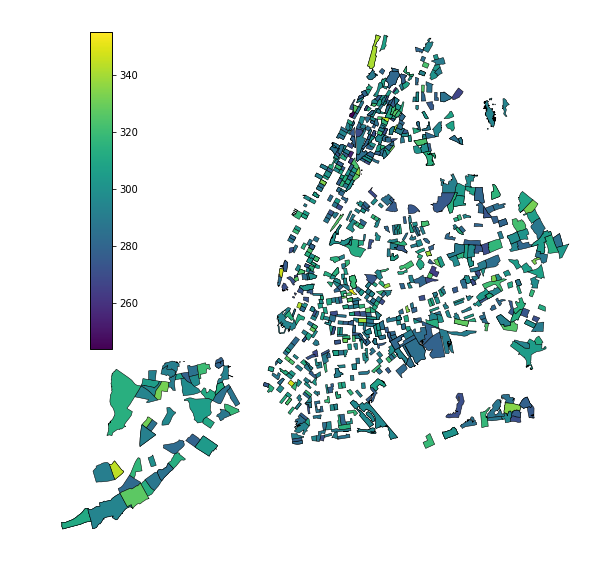

In [55]:
#graphing 2013 mean English scores by census tract
cp.choroplethNYC(geoscores2013_short, column="Eng2013_Mean", color="k",cmap="viridis", edgecolor="k", lw=0.5);

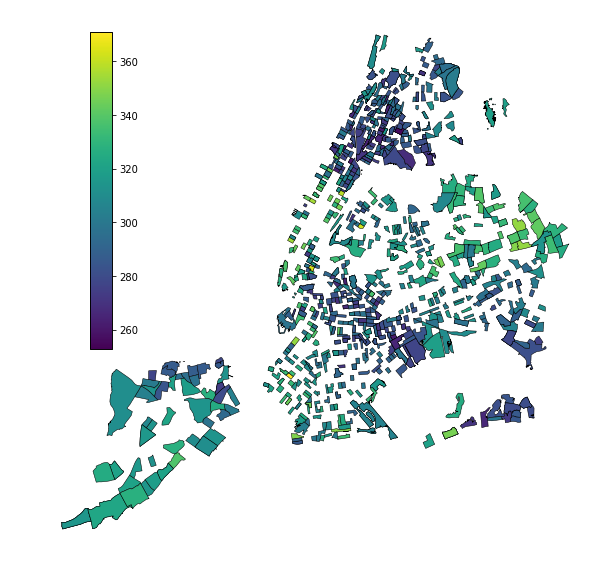

In [56]:
#graphing 2013 mean math scores by census tract
cp.choroplethNYC(geoscores2015_short, column="Math2015_Mean", color="k",cmap="viridis", edgecolor="k", lw=0.5);

In [57]:
#now we can merge test scores by census tract with noise complaints by census tract
#load in noise complaint data
noise13 = pd.read_csv("noisebyct2013.csv")
noise14 = pd.read_csv("noisebyct2014.csv")
noise15 = pd.read_csv("noisebyct2015.csv")

In [58]:
print(noise13.shape)
print(noise14.shape)
print(noise15.shape)

(2028, 15)
(2054, 15)
(2070, 15)


In [59]:
#shorten noise complaints data to only contain census tract, number of complaints, and complaint density
noise13 = noise13[["boro_ct201", "count_vals", "count_vals_density"]]
noise14 = noise14[["boro_ct201", "count_vals", "count_vals_density"]]
noise15 = noise15[["boro_ct201", "count_vals", "count_vals_density"]]

In [60]:
print(noise13.shape)
print(noise14.shape)
print(noise15.shape)

(2028, 3)
(2054, 3)
(2070, 3)


In [61]:
#convert census tracts to string
noise13["boro_ct201"] = noise13["boro_ct201"].astype(str)
noise14["boro_ct201"] = noise14["boro_ct201"].astype(str)
noise15["boro_ct201"] = noise15["boro_ct201"].astype(str)

In [62]:
scores2013_final = pd.merge(noise13, geoscores2013_short, left_on="boro_ct201", right_on="BoroCT2010")
scores2014_final = pd.merge(noise14, geoscores2014_short, left_on="boro_ct201", right_on="BoroCT2010")
scores2015_final = pd.merge(noise15, geoscores2015_short, left_on="boro_ct201", right_on="BoroCT2010")

In [63]:
scores2013_final.head()

,boro_ct201_x,count_vals,count_vals_density,the_geom,BoroCode,BoroCT2010,LOCATION_NAME,LOCATION_TYPE_DESCRIPTION,LOCATION_CATEGORY_DESCRIPTION,X_COORDINATE,...,ct2010,ntaname,ntacode,boro_name,shape_leng,shape_area,cdeligibil,boro_code,ctlabel,geometry
0,2023301,8,0.000068,MULTIPOLYGON (((-73.8879964361467 40.816663385...,2,2023301,P.S. 048 Joseph R. Drake,General Academic,Elementary,1015575.0,...,023301,Mount Hope,BX41,Bronx,4498.012387,1.272774e+06,E,2,233.01,POLYGON ((-73.90698472353698 40.85038248671983...
1,2023301,8,0.000068,MULTIPOLYGON (((-73.87663459963709 40.81571150...,2,2023301,The Hunts Point School,General Academic,Junior High-Intermediate-Middle,1016003.0,...,023301,Mount Hope,BX41,Bronx,4498.012387,1.272774e+06,E,2,233.01,POLYGON ((-73.90698472353698 40.85038248671983...
2,2023301,8,0.000068,MULTIPOLYGON (((-73.7576312961815 40.666451156...,4,2023301,P.S. 052 Queens,General Academic,Elementary,1048849.0,...,023301,Mount Hope,BX41,Bronx,4498.012387,1.272774e+06,E,2,233.01,POLYGON ((-73.90698472353698 40.85038248671983...
3,1007100,105,0.000636,MULTIPOLYGON (((-73.83737956188475 40.89392474...,2,1007100,P.S. 068 Bronx,General Academic,Elementary,1028797.0,...,007100,West Village,MN23,Manhattan,6601.034466,1.775751e+06,I,1,71,"POLYGON ((-73.9968399392649 40.7373608893982, ..."
4,3064600,6,0.000036,MULTIPOLYGON (((-73.92842985426594 40.61497277...,3,3064600,P.S. 207 Elizabeth G. Leary,General Academic,K-8,1003550.0,...,064600,Georgetown-Marine Park-Bergen Beach-Mill Basin,BK45,Brooklyn,5619.588955,1.782721e+06,I,3,646,POLYGON ((-73.93605774303619 40.61512319639314...


In [64]:
#convert to geo dataframe for mapping 
geoscores2015_final = gp.GeoDataFrame(scores2015_final)
geoscores2013_final = gp.GeoDataFrame(scores2013_final)
geoscores2014_final = gp.GeoDataFrame(scores2014_final)

In [65]:
#convert all test scores to int
geoscores2013_final["Eng2013_Mean"] = geoscores2013_final["Eng2013_Mean"].astype(int)
geoscores2014_final["Eng2014_Mean"] = geoscores2014_final["Eng2014_Mean"].astype(int)
geoscores2015_final["Eng2015_Mean"] = geoscores2015_final["Eng2015_Mean"].astype(int)

geoscores2013_final["Math2013_Mean"] = geoscores2013_final["Math2013_Mean"].astype(int)
geoscores2014_final["Math2014_Mean"] = geoscores2014_final["Math2014_Mean"].astype(int)
geoscores2015_final["Math2015_Mean"] = geoscores2015_final["Math2015_Mean"].astype(int)

In [68]:
#now create graphs to examine the effect noise complaints on test scores
import matplotlib.pyplot as plt

Text(0.5,0.98,'Effect of Noise Complaints of 2013 Math Scores')

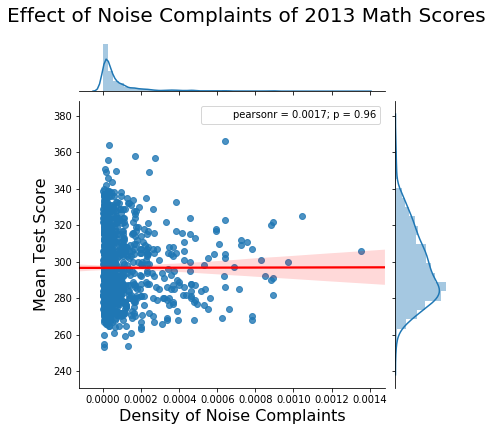

In [73]:
math2013_trend = sn.jointplot("count_vals_density", "Math2013_Mean", data =geoscores2013_final, kind="reg",
                  joint_kws={"line_kws":{"color":"red"}}).set_axis_labels('Density of Noise Complaints', 'Mean Test Score', fontsize=16)
plt.subplots_adjust(top=0.9)
math2013_trend.fig.suptitle('Effect of Noise Complaints of 2013 Math Scores', fontsize=20)

Text(0.5,0.98,'Effect of Noise Complaints of 2013 Math Scores')

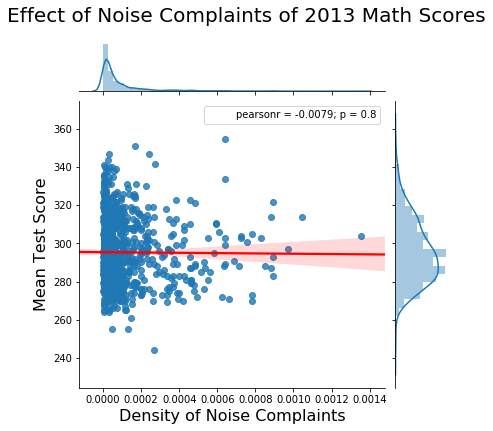

In [74]:
eng2013_trend = sn.jointplot("count_vals_density", "Eng2013_Mean", data =geoscores2013_final, kind="reg",
                  joint_kws={"line_kws":{"color":"red"}}).set_axis_labels('Density of Noise Complaints', 'Mean Test Score', fontsize=16)
plt.subplots_adjust(top=0.9)
eng2013_trend.fig.suptitle('Effect of Noise Complaints of 2013 English Scores', fontsize=20)

Text(0.5,0.98,'Effect of Noise Complaints of 2014 Math Scores')

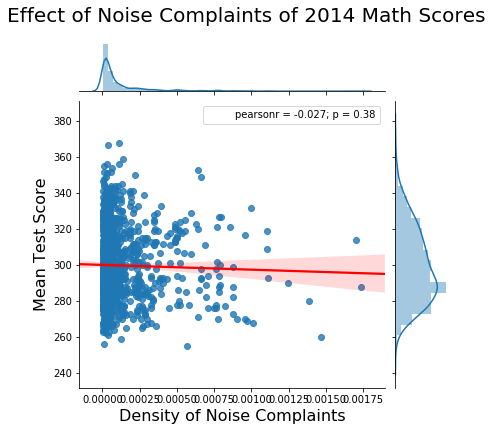

In [75]:
math2014_trend = sn.jointplot("count_vals_density", "Math2014_Mean", data =geoscores2014_final, kind="reg",
                  joint_kws={"line_kws":{"color":"red"}}).set_axis_labels('Density of Noise Complaints', 'Mean Test Score', fontsize=16)
plt.subplots_adjust(top=0.9)
math2014_trend.fig.suptitle('Effect of Noise Complaints of 2014 Math Scores', fontsize=20)

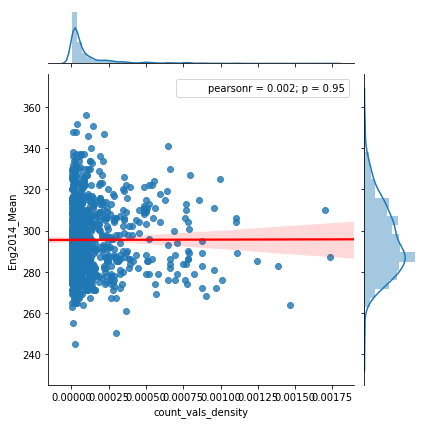

In [100]:
eng2014_trend = sn.jointplot("count_vals_density", "Eng2014_Mean", data =geoscores2014_final, kind="reg",
                  joint_kws={"line_kws":{"color":"red"}}).set_axis_labels('Density of Noise Complaints', 'Mean Test Score', fontsize=16)
plt.subplots_adjust(top=0.9)
eng2014_trend.fig.suptitle('Effect of Noise Complaints of 2014 English Scores', fontsize=20)

Text(0.5,0.98,'Effect of Noise Complaints of 2015 Math Scores')

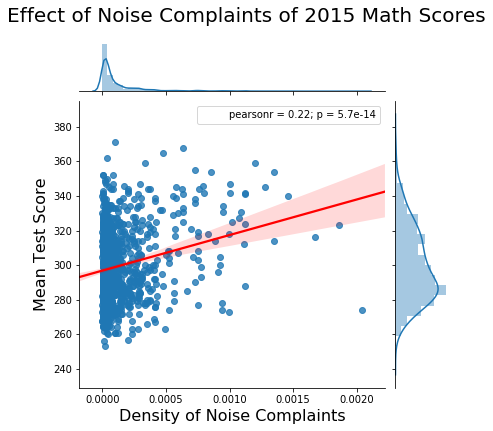

In [77]:
math2015_trend = sn.jointplot("count_vals_density", "Math2015_Mean", data =geoscores2015_final, kind="reg",
                  joint_kws={"line_kws":{"color":"red"}}).set_axis_labels('Density of Noise Complaints', 'Mean Test Score', fontsize=16)
plt.subplots_adjust(top=0.9)
math2015_trend.fig.suptitle('Effect of Noise Complaints of 2015 Math Scores', fontsize=20)

Text(0.5,0.98,'Effect of Noise Complaints of 2015 English Scores')

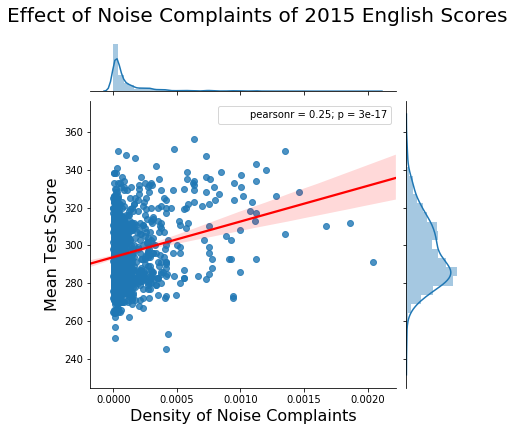

In [76]:
eng2015_trend = sn.jointplot("count_vals_density", "Eng2015_Mean", data =geoscores2015_final, kind="reg",
                  joint_kws={"line_kws":{"color":"red"}}).set_axis_labels('Density of Noise Complaints', 'Mean Test Score', fontsize=16)
plt.subplots_adjust(top=0.9)
eng2015_trend.fig.suptitle('Effect of Noise Complaints of 2015 English Scores', fontsize=20)

In [103]:
#save dataframes to csv
geoscores2013_final.to_csv("scores2013.csv")
geoscores2014_final.to_csv("scores2014.csv")
geoscores2015_final.to_csv("scores2015.csv")

# SECTION 3. 311 LODES DATA MUNGING 

# SECTION 4.  FINAL MERGE  AND MODELS